# | HW3 | MobileNetV2 변형해 보기

**Due: 8/19 14:00**

---

`BatchNormalization(axis, momentum, epsilon)` : https://keras.io/api/layers/normalization_layers/batch_normalization/
- axis: Batch normalization이 적용될 axis. 우리는 채널에 대해서 BN을 적용할 것이다. 
- momentum: Moving average에 적용될 momentum 계수
- epsilon: 0으로 나누는 것을 방지하기 위한 작은 수.


`DepthwiseConv2D(kernel_size, strides, padding, use_bias, depthwise_regularizer)` : https://keras.io/api/layers/convolution_layers/depthwise_convolution2d/

paper:[MobileNetV3](https://openaccess.thecvf.com/content_ICCV_2019/papers/Howard_Searching_for_MobileNetV3_ICCV_2019_paper.pdf)  

이번 과제에서는 MobileNetV3에서 추가된 내용 중 일부를 반영해 볼 것이다. MobilenetV3에서는 모델의 마지막 부분에 아래 그림과 같은 변화가 있었는데, 요약하자면
* Average pooling 앞의 1x1 Convolution layer와 Average pooling layer의 순서를 바꾸어 줌으로써 Computation은 줄이면서 정보의 손실은 최소화하였다.
* 위 변화가 일어나게 됨으로써 그 이전 Inverted residual layer에서 projection/filtering을 해 줄 필요가 없어졌다. 따라서 마지막 Inverted residual layer의 Expansion 이후 바로 Average pooling이 오게 된다.
* 아래 그림을 보면 더 이해가 쉬울 것이다.
<img src="https://user-images.githubusercontent.com/37704174/112775642-734f8a80-9078-11eb-9bc1-a860a1fea407.PNG" width="700" height="700"/> 
* 마지막 Inverted residual layer는 Original last stage 그림에서 맨 앞 세개이다.


<br>
위 내용을 참조하여 Network의 마지막 부분을 변형한 MobileNetV2plus를 구성하라. 위 그림상의 H-swish는 고려하지 않아도 된다.
<img src="https://user-images.githubusercontent.com/37704174/112777027-1229b600-907c-11eb-9f89-a7b61c0843be.PNG" width="700" height="700"/>  

- **채점기준**
  - 위의 변경 사항 반영하기
    - MobileNetV2에서 마지막 inverted residual block 및 뒷부분을 고치면 됨
    - Average pooling의 output의 가로 세로는 1임
  - test accuracy **80%** 이상
    - BatchNormalization, Activation, Dropout, Regularization, Weight initialization 등 자유롭게 수정, 추가, 제거 가능
    - `strides` 수정 가능
    - 나머지는 그대로


## Import Modules

In [ ]:
import tensorflow as tf
### Q1. Import modules ###

#########################

## Inverted Residual Block

- 실습 때 한 것과 동일 

In [ ]:
def _inverted_res_block(inputs, expansion, filters, strides):
    x = inputs
    in_chnls = inputs.shape[-1]
    # Expansion
    if expansion != 1:
        x = Conv2D(kernel_size=1, filters=in_chnls * expansion, strides=1, padding='same', use_bias=False, kernel_regularizer=l2(4e-5))(x)
        x = BatchNormalization(momentum=0.999, epsilon=0.001)(x)
        x = ReLU(max_value=6)(x)
        
    # Depthwise convolution
    x = DepthwiseConv2D(kernel_size=3, strides=strides, padding='same', use_bias=False, depthwise_regularizer=l2(4e-5))(x)
    x = BatchNormalization(momentum=0.999, epsilon=0.001)(x)
    x = ReLU(max_value=6)(x)
    
    # Linear bottleneck
    x = Conv2D(kernel_size=1, filters=filters, strides=1, padding='same', use_bias=False, kernel_regularizer=l2(4e-5))(x)
    x = BatchNormalization(momentum=0.999, epsilon=0.001)(x)
    # No activation
    
    # Residual connection
    if in_chnls == filters and strides == 1:
        x = Add()([inputs, x])
        
    return x #return output of layer

## MobileNetV2 변형 구현

In [ ]:
def MobileNetV2plus(input_shape, classes):
    inputs = Input(shape=input_shape)
    
    ### Q2. Modify MobileNetV2 ###
    
    
    outputs = Dense(...)(x)
    ##############################
                                    
    return Model(inputs=inputs, outputs=outputs)


In [ ]:
my_mobilenet = MobileNetV2plus((32,32,3),classes=10)

## Training Data

- keras dataset 혹은 tensorflow dataset 이용
- train data를 9:1로 나눠서 validation data로 이용

In [ ]:
from tensorflow.keras.datasets import cifar10
#Load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#Split train set into train/valid set
from sklearn import model_selection
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(x_train, y_train,test_size=0.1)

## Data Preprocessing
자유롭게 전처리

In [ ]:
### Q3. Preporcessing ###

#########################

## Model Compile
loss function, optimizer 설정

In [ ]:
### Q4. Model compile ###

#########################

In [ ]:
### Q5. Callbacks ###
callbacks = []
#callbacks.append(tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1))
callbacks.append(tf.keras.callbacks. ...)
#####################

## Model Training
hyperparameter를 적절히 설정한다. (epochs 등..)

In [ ]:
### Q6. Training ###
history = my_mobilenet.fit(x_train, y_train, batch_size=, 
                          epochs=,
                          callbacks=callbacks,              
                          validation_data=(x_valid, y_valid))
####################

## 참고용
조교가 학습한 모델의 validation accuracy를 그래프로 나타내 보았다.

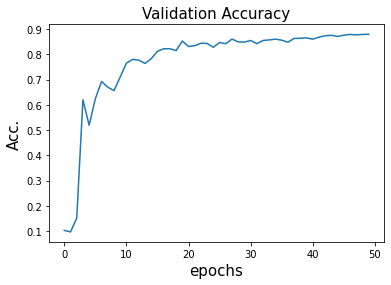

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_accuracy'])
plt.title('Validation Accuracy', fontsize=15)
plt.xlabel('epochs', fontsize=15)
plt.ylabel('Acc.', fontsize=15)

plt.show()

## Test Accuracy

test accuracy 측정 결과 **80% 이상**이 나와야 한다.

In [ ]:
my_mobilenet.evaluate(x_test,y_test)

313/313 [==============================] - 4s 10ms/step - loss: 0.7716 - accuracy: 0.8799


[0.7716487050056458, 0.8798999786376953]